# Overview

**GENERAL THOUGHTS:**



**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

continuous data:
- Impute missing data: SimpleImputer(strategy='median')
- Standardize data: StandardScaler()

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent')
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
- Unknown values ecoding: custom encoder "OrdinalEncoderExtensionUnknowns()"

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

**MULTI-CLASS CLASSIFIER:**
- Overview models to be considered:  
Models:
  - [X] Neural Net: MLP with categorical variable embedding (embMLP)


In [1]:
colab = True

In [2]:
if colab:
  # Import the library to mount Google Drive
  from google.colab import drive
  # Mount the Google Drive at /content/drive
  drive.mount('/content/drive')
  # Verify by listing the files in the drive
  # !ls /content/drive/My\ Drive/
  # current dir in colab
  !pwd

Mounted at /content/drive
/content


In [3]:
if colab:
    !pip install optuna==3.5.0
    # !pip install optuna.integration
    !pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 40.2 MB/s eta 0:00:00


In [4]:
# import os
import sys
import yaml

# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import optuna
from optuna.integration import PyTorchLightningPruningCallback

import lightning as L
from lightning.pytorch.tuner import Tuner
import torch
from torch import nn
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping

from typing import Dict, Iterable, List, Optional, Tuple, Union, Literal

In [5]:
# NOTE: if used in google colab, upload env_vars_colab.yml to current google colab directory!

# get config
if colab:
    with open('./env_vars_colab.yml', 'r') as file:
        config = yaml.safe_load(file)

    # custom imports
    sys.path.append(config['project_directory'])
else:
    with open('../env_vars.yml', 'r') as file:
        config = yaml.safe_load(file)

    # custom imports
    sys.path.append(config['project_directory'])

from src.tabular_lightning import TabularDataModuleClassificationPACKAGING, MulticlassTabularLightningModule
from src import tabular_lightning_utils as tl_utils

In [6]:
SEED = 42 # Ensure same data split as in other notebooks

# Datasets, DataLoaders & LightningDataModule
- Logic of using `Datasets`, `DataLoaders` & `LightningDataModule` for **Tabular Data**  
    Since we are using tabular data and want to perform non tensor based processing to our date, we use Datasets, DataLoaders & LightningDataModule in a different manner as we would do when applying tensor operations (incl. tensor based preprpcessing) only.  
    - `LightningDataModule`
        Our LightningDataModule builds the wrapper around this process, with the following intensions:
        - `def prepare_data`  
        Data Operations that only should be performed once on the data (and should not be performed on a distributed manner). Prepares the data for data pre-processing e.g. using sklearn.  
            - Loading the data from .csv to pd.DataFrame
            - General dataset preperations like feature selection and data type correction
        - `def setup`  
        First, data operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader will be performed here. Since we use sklearn functionalities for our tabular pre-processing pipeline the data input and output of the pre-processing is a tabular format (dataframe) and not a tensor format.
        Second, the outcome of `def setup` are `Dataset` objects for each split (e.g. train, val, test, pred), which is a wrapper around the pre-processed tabular data and provides the samples and their corresponding labels (ideally in tensor format) in a specific way to be compatible for the model(s).
            - `Dataset`  
            Dataset provides the samples and their corresponding labels in a specific way to be compatible for the model(s). We define the input for our tabular use case as a DataFrame, while the output should generally be a tensor. In our case the output is a tuple of a flattern tensor representing all features and a tensor for the target variable (label). This aligns with the input if a simple MLP model. For more complex models, e.g. that handle continous and categorical variables differently, this should be adapted.  
            The class performs specific data type correction for to use of Neural Networks (e.g. ensure that all outputs are numeric values of the correct type depeding of they are categorical or continous nature).
        - `def train/val/test/prediction_dataloader`  
        Creates our dataloaders within the LightningDataModule. See usage below.
            - `DataLoader`
            DataLoader wraps an iterable around the Dataset to enable easy access to the samples during training and inference. The Dataset defines the format of the data that is passed to our model. The DataLoader retrieves our dataset’s features and labels. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval, which is handled by the DataLoader. Input and output is a tensor. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Excorsion: Classical approach of using `Datasets`, `DataLoaders` & `LightningDataModule` for e.g. images, ...  
The main difference is the usage of tensors instead of a dataframe for efficent GPU usage.
    - `LightningDataModule`
        Our LightningDataModule builds the wrapper around this process. It encapsulates training, validation, testing, and prediction dataloaders, as well as any necessary steps for data processing, downloads, and transformations. https://lightning.ai/docs/pytorch/stable/data/datamodule.html
        - `def prepare_data`  
        Loads the data and does general processing befor transfomring to a tensor, so efficent tensor operations can be enabled in `setup'.
        - `def setup`  
        Efficent tensor operations (like shuffle, split data, categorical encoding, normalization, etc.), which any dataframe should undergo before feeding into the dataloader.
        - `def train/val/test_dataloader`  
        Creates our dataloaders within the LightningDataModule.
    - `Dataset`
    Class to create tabular dataset to follow PyTorch Lightning conventions (eventhough we are working on tabular data), where the data for feature variables and the target variable are often already provided in a combined way (e.g. contrary to images and corresbonding labels). For "classical" approaches a Dataset class is often used at the start of the machine learning pipeline to provide the data in a format (e.g. combine images and corresponding labels, which are typically not provided in the same file) for further processing and training.

# Load and Pre-process Data

In [7]:
dm = TabularDataModuleClassificationPACKAGING(
    data_dir=f"{config['data_directory']}/output/df_ml.csv",
    continuous_cols=['material_weight'],
    categorical_cols=[
        'material_number',
        'brand',
        'product_area',
        'core_segment',
        'component',
        'manufactoring_location',
        'characteristic_value',
        'packaging_code'
    ],
    target=['packaging_category'],
    oversampling=True,
    test_size=0.2,
    val_size=0.2,
    batch_size=64,
    num_workers_train=0, # (os.cpu_count() / 2)
    num_workers_inference=0, # (os.cpu_count() / 2)
    SEED=SEED
)

In [8]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build the model.
dm.prepare_data()
dm.setup(stage='fit')
# dm.data.info()
# dm.data.head()

In [9]:
dm.train_dataset.get_dataframe.head(5)

,material_weight,material_number,brand,product_area,core_segment,component,manufactoring_location,characteristic_value,packaging_code,packaging_category
0,-0.014936,2435,6,2,13,8421,17,282,35,1
1,-0.015001,10594,6,2,20,8355,17,282,33,22
2,-0.014273,6018,3,2,17,91,13,353,57,26
3,-0.015043,18002,2,3,3,12257,11,291,86,0
4,-0.015105,5511,2,1,8,4312,11,291,58,13


In [10]:
tl_utils.check_data_consitancy(dm)

In [11]:
tl_utils.check_dataloader_output(dm, next(iter(dm.train_dataloader())))

In [12]:
tl_utils.print_dataloader_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Target from current batch: tensor([[24],
        [13],
        [12],
        [ 8],
        [18]])
Dataloader output from current batch, Cont: tensor([[-0.0149],
        [-0.0129],
        [-0.0150]])
Dataloader output from current batch, Cat: tensor([[11760,     6,     2,    13,  5991,    17,   142,    52],
        [14435,     3,     2,    17,   725,    13,   295,    54],
        [ 3913,     2,     1,    11, 12257,     3,   291,    86]])
Batch: 1


# Models and Training/HPO

## Embbeding MLP without HPO

In [13]:
tabular_data_full = pd.concat([dm.train_dataset.get_dataframe, dm.val_dataset.get_dataframe, dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=dm.categorical_cols)
embedding_sizes_cat_features

{'material_number': (22537, 100),
 'brand': (11, 6),
 'product_area': (6, 4),
 'core_segment': (23, 9),
 'component': (12359, 100),
 'manufactoring_location': (24, 9),
 'characteristic_value': (473, 50),
 'packaging_code': (128, 24)}

In [14]:
tl_utils.print_embbeding_input_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Dataloader output from current batch, Cont:
 tensor([[-0.0148],
        [-0.0146],
        [-0.0151]])
Dataloader output from current batch, Cat:
 tensor([[  593,     2,     2,    13,  7252,    17,    53,    35],
        [ 5472,     6,     1,     8, 12261,    11,   291,    80],
        [19884,     6,     2,    20, 11576,    17,   461,    58]])
material_number - Min, Max:  tensor(260) tensor(22515)
brand - Min, Max:  tensor(1) tensor(10)
product_area - Min, Max:  tensor(1) tensor(5)
core_segment - Min, Max:  tensor(3) tensor(21)
component - Min, Max:  tensor(3) tensor(12298)
manufactoring_location - Min, Max:  tensor(3) tensor(

In [15]:
class MulticlassTabularCatEmbeddingMLP(torch.nn.Module):
    def __init__(
        self,
        continuous_cols: List[str] = None,
        categorical_cols: List[str] = None,
        output_size: int = None,
        # embedding_dim: int = None,
        hidden_size: int = None,
        n_hidden_layers: int = None,
        activation_class: torch.nn.functional = nn.ReLU,
        dropout: float = None,
        norm: bool = True,
        embedding_sizes: (Dict[str, Tuple[int, int]]) = None,
    ):
        """Embedding Multi Layer Perceptron (embMLP) with embedding for categorical features for multiclass classification for tabular data.
        Args:
            continues_cols (List[str]): order of continuous variables in tensor passed to forward function.
            categorical_cols (List[str]): order of categorical variables in tensor passed to forward function.
            output_size (int): Number of output classes.
            hidden_size (int): Number of neurons in hidden layers.
            n_hidden_layers (int): Number of hidden layers.
            activation_class (torch.nn.functional): Activation function.
            dropout (float): Dropout rate.
            norm (bool): Whether to use layer normalization.
            embedding_sizes (Dict[str, Tuple[int, int]]): Dictionary of embedding sizes for each categorical feature.
        """
        super().__init__()
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.output_size = output_size
        self.embedding_sizes = embedding_sizes
        # self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.activation_class = activation_class
        self.dropout = dropout
        self.norm = norm

        ### define the Embedding MLP ###
        ## embedding layers
        # cont featurres
        self.cont_normalizing = nn.BatchNorm1d(len(self.continuous_cols))
        # cat features
        self.cat_embeddings = nn.ModuleDict()
        for name in embedding_sizes.keys():
            self.cat_embeddings[name] = nn.Embedding(
                embedding_sizes[name][0],
                embedding_sizes[name][1],
            )
        ## input layer mlp
        mlp_input_size = sum(value[1] for value in embedding_sizes.values()) + len(self.continuous_cols)
        module_list = [nn.Linear(mlp_input_size, hidden_size), activation_class()]
        if dropout is not None:
            module_list.append(nn.Dropout(dropout))
        if norm:
            module_list.append(nn.LayerNorm(hidden_size))
        ## hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), activation_class()])
            if dropout is not None:
                module_list.append(nn.Dropout(dropout))
            if norm:
                module_list.append(nn.LayerNorm(hidden_size))
        ## output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.mlp_layers = nn.Sequential(*module_list)

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the embMLP."""

        assert "continuous" in x or "categorical" in x, "x must contain either continuous or categorical features"

        ### forward embedding layers ###
        # cont features
        if len(self.continuous_cols) > 0:
            embed_vector_cont = self.cont_normalizing(x["continuous"])
        else:
            embed_vector_cont = x["continuous"]
        # cat features
        if len(self.categorical_cols) > 0:
            output_vectors = {}
            for idx, (name, emb) in enumerate(self.cat_embeddings.items()):
                output_vectors[name] = emb(x["categorical"][:, idx])
            embed_vector_cat = torch.cat(list(output_vectors.values()), dim=1)
        # output_vector_emded
        if embed_vector_cont is None:
            output_vector_emded = embed_vector_cat
        else:
            output_vector_emded = torch.cat([embed_vector_cont, embed_vector_cat], dim=1)

        ### forward hidden layers ###
        return self.mlp_layers(output_vector_emded)

In [16]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build your model.
multiclass_embMLP = MulticlassTabularCatEmbeddingMLP(
    continuous_cols=dm.continuous_cols,
    categorical_cols=dm.categorical_cols,
    output_size=dm.n_classes,
    hidden_size=64,
    n_hidden_layers=3,
    dropout=0.2,
    norm=True,
    embedding_sizes=embedding_sizes_cat_features
)

In [17]:
tl_utils.print_model_summary(multiclass_embMLP)

Parameter name: cont_normalizing.weight, Shape: torch.Size([1])
Parameter name: cont_normalizing.bias, Shape: torch.Size([1])
Parameter name: cat_embeddings.material_number.weight, Shape: torch.Size([22537, 100])
Parameter name: cat_embeddings.brand.weight, Shape: torch.Size([11, 6])
Parameter name: cat_embeddings.product_area.weight, Shape: torch.Size([6, 4])
Parameter name: cat_embeddings.core_segment.weight, Shape: torch.Size([23, 9])
Parameter name: cat_embeddings.component.weight, Shape: torch.Size([12359, 100])
Parameter name: cat_embeddings.manufactoring_location.weight, Shape: torch.Size([24, 9])
Parameter name: cat_embeddings.characteristic_value.weight, Shape: torch.Size([473, 50])
Parameter name: cat_embeddings.packaging_code.weight, Shape: torch.Size([128, 24])
Parameter name: mlp_layers.0.weight, Shape: torch.Size([64, 303])
Parameter name: mlp_layers.0.bias, Shape: torch.Size([64])
Parameter name: mlp_layers.3.weight, Shape: torch.Size([64])
Parameter name: mlp_layers.3.b

In [18]:
lightningmodel = MulticlassTabularLightningModule(
    n_classes=dm.n_classes,
    model=multiclass_embMLP,
    learning_rate=0.001,
)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.012022644346174132
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.012022644346174132
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ae48132c-adea-439f-9ab2-fb98649180e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ae48132c-adea-439f-9ab2-fb98649180e6.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ae48132c-adea-439f-9ab2-fb98649180e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ae48132c-adea-439f-9ab2-fb98649180e6.ckpt


0.012022644346174132


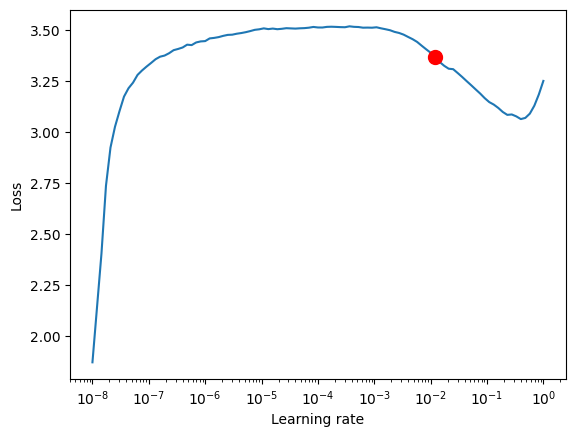

In [19]:
empmlp_experiment_name = "embMLP-v0"

trainer = L.Trainer(
    devices="auto", # (os.cpu_count() / 2)
    callbacks=[
        EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        # L.ModelCheckpoint(
        #     monitor="val_loss",
        #     mode="min",
        #     save_top_k=1,
        #     save_path=f"{save_path}/checkpoints",
        #     filename="best_model",
        # ),
    ],
    logger=CSVLogger(save_dir="logs/", name=empmlp_experiment_name),
    max_epochs=2,
    precision='bf16-mixed',
    default_root_dir="lightning_logs/",
)

# create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically, update hparams.lr to that learning rate
lr_finder = tuner.lr_find(lightningmodel, datamodule=dm)
fig = lr_finder.plot(suggest=True)
#fig.savefig("lr_suggest.pdf")
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
lightningmodel.learning_rate = new_lr

In [20]:
# training
trainer.fit(model=lightningmodel, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader()) # stage of the dataloader to use

INFO: 
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.205    Total estimated model params size (MB)
32        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


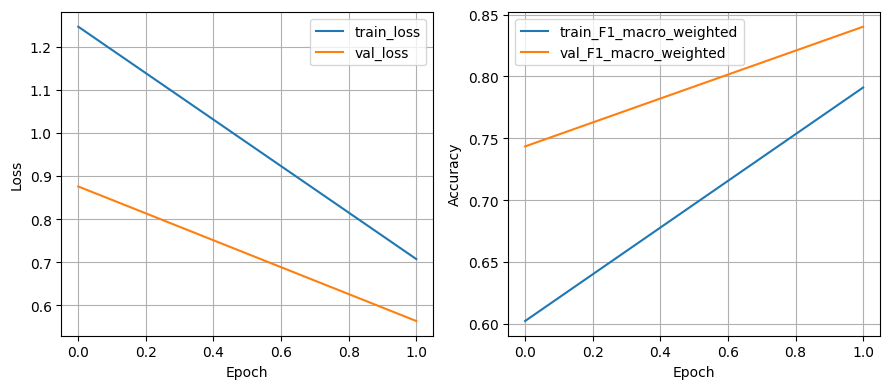

,epoch,step,train_F1_macro_weighted,train_loss,val_F1_macro_weighted,val_loss
0,0,469.333333,0.602331,1.246784,0.743472,0.875801
1,1,1292.789474,0.791077,0.707260,0.840226,0.563450


In [21]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

tl_utils.plot_training_metrics(metrics)

In [22]:
score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.8439362049102783     │
└───────────────────────────┴───────────────────────────┘

In [23]:
score[0]['test_F1_macro_weighted']

0.8439362049102783

In [24]:
# make predictions on test data and evaluate
preds_y_test = torch.cat(trainer.predict(model=lightningmodel, dataloaders=dm.test_dataloader()))
# inverse transform to get back to original labels
preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
# calculate classification report
print(classification_report(y_test, preds_y_test))

Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                            precision    recall  f1-score   support

   Blister and Insert Card       0.88      0.93      0.90      1749
  Blister and sealed blist       0.87      0.92      0.89      1582
            Book packaging       0.00      0.00      0.00        20
Cardb. Sleeve w - w/o Shr.       1.00      0.01      0.03       135
  Cardboard hanger w/o bag       0.77      0.55      0.64        80
    Carton cover (Lid box)       0.74      0.48      0.58       130
   Carton tube with or w/o       1.00      0.05      0.10        20
                      Case       0.39      0.30      0.34        97
         Corrugated carton       0.94      0.74      0.83       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       0.94      0.75      0.83        59
          Fabric packaging       0.86      0.30      0.44        20
            Folding carton       0.85      0.82      0.83      1644
              Hanger/ Clip       0.93      0.97

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Embedding MLP with HPO

### Performe HPO

In [25]:
class OptunaObjective(object):
    """Optuna objective for hyperparameter tuning."""
    def __init__(self, dm: TabularDataModuleClassificationPACKAGING = None):
        self.dm = dm
        self.dm.prepare_data()
        self.dm.setup(stage='fit')

        tabular_data_full = pd.concat([self.dm.train_dataset.get_dataframe, self.dm.val_dataset.get_dataframe, self.dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
        self.embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=self.dm.categorical_cols)

    def __call__(self, trial: optuna.Trial) -> float:

        # joblib.dump(study, 'study.pkl')

        # Define the hyperparameter search space
        hp_space_optuna = {
            'hidden_size': trial.suggest_categorical('hidden_size', [8, 16, 32, 64, 128]), # number of neurons in each layer
            'n_hidden_layers': trial.suggest_int("n_hidden_layers", 1, 6), # number of layers
            'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]), # number of samples per batch
            'dropout': trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.4]), # dropout rate
        }
        self.dm.batch_size = hp_space_optuna['batch_size']
        # Create a model
        model = MulticlassTabularCatEmbeddingMLP(
            continuous_cols=self.dm.continuous_cols,
            categorical_cols=self.dm.categorical_cols,
            output_size=self.dm.n_classes,
            hidden_size=hp_space_optuna['hidden_size'],
            n_hidden_layers=hp_space_optuna['n_hidden_layers'],
            dropout=hp_space_optuna['dropout'],
            embedding_sizes=self.embedding_sizes_cat_features
        )
        # Create a LightningModule
        lightningmodel = MulticlassTabularLightningModule(
            n_classes=self.dm.n_classes,
            model=model,
            learning_rate=0.001,
        )
        # Create a trainer
        trainer = L.Trainer(
            devices="auto", # (os.cpu_count() / 2)
            callbacks=[
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
            ],
            # logger=CSVLogger(save_dir="logs/", name="my-model"),
            max_epochs=2,
            precision='bf16-mixed',
            default_root_dir="lightning_logs/",
        )
        # Create a Tuner
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(lightningmodel, datamodule=self.dm) # finds learning rate automatically
        new_lr = lr_finder.suggestion()
        lightningmodel.learning_rate = new_lr # update hparams of the model
        # Train the model
        trainer.fit(
            model=lightningmodel,
            train_dataloaders=self.dm.train_dataloader(),
            val_dataloaders=self.dm.val_dataloader()
        )

        # score = trainer.test(model=lightningmodel, dataloaders=self.dm.test_dataloader())
        # score[0]['test_F1_macro_weighted']

        return trainer.callback_metrics["val_F1_macro_weighted"].item()

In [26]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=64,
        SEED=SEED
    )
)

# define and run study for optimization
storage_name = f"sqlite:///{config['optuna_storage_directory']}/{empmlp_experiment_name}.db"
study = optuna.create_study(
    study_name=empmlp_experiment_name,
    storage=storage_name,
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner()
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=1,
    # timeout=600,
    show_progress_bar=True
)

[I 2024-11-04 20:15:06,972] Using an existing study with name 'embMLP-v0' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.07585775750291836
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.07585775750291836
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ffc015e8-7781-480e-b1eb-fda151f8fe8e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ffc015e8-7781-480e-b1eb-fda151f8fe8e.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ffc015e8-7781-480e-b1eb-fda151f8fe8e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ffc015e8-7781-480e-b1eb-fda151f8fe8e.ckpt
INFO: 
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbedding

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


[I 2024-11-04 20:19:09,851] Trial 1 finished with value: 0.8287327289581299 and parameters: {'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.2}. Best is trial 1 with value: 0.8287327289581299.


In [27]:
# print optimization results
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

Number of finished trials: 2
Best trial:
  Performance:  0.8287327289581299
  Best trial: {'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.2}


### Analyse Optuna study

In [28]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_hidden_size,params_n_hidden_layers,state
0,0,NaN,2024-11-04 20:17:31.496217,NaT,NaT,32,0.2,16,1,RUNNING
1,1,0.828733,2024-11-04 20:15:07.046099,2024-11-04 20:19:09.692247,0 days 00:04:02.646148,32,0.2,16,1,COMPLETE


In [29]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [30]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [31]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [32]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

[W 2024-11-04 20:19:11,489] Param dropout unique value length is less than 2.
[W 2024-11-04 20:19:11,493] Param hidden_size unique value length is less than 2.
[W 2024-11-04 20:19:11,496] Param n_hidden_layers unique value length is less than 2.
[W 2024-11-04 20:19:11,498] Param batch_size unique value length is less than 2.
[W 2024-11-04 20:19:11,500] Param hidden_size unique value length is less than 2.
[W 2024-11-04 20:19:11,503] Param n_hidden_layers unique value length is less than 2.
[W 2024-11-04 20:19:11,503] Param batch_size unique value length is less than 2.
[W 2024-11-04 20:19:11,506] Param dropout unique value length is less than 2.
[W 2024-11-04 20:19:11,509] Param n_hidden_layers unique value length is less than 2.
[W 2024-11-04 20:19:11,510] Param batch_size unique value length is less than 2.
[W 2024-11-04 20:19:11,511] Param dropout unique value length is less than 2.
[W 2024-11-04 20:19:11,514] Param hidden_size unique value length is less than 2.


### Evaluate best model

In [33]:
best_trial.params

{'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.2}

In [34]:
# Define best model

best_params = best_trial.params

# Evaluate best model on test data again
def eval_best_model(best_params):
    # datamodule
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=best_params['batch_size'],
        SEED=SEED
    )
    dm.prepare_data()
    dm.setup(stage='fit')
    # model
    tabular_data_full = pd.concat([dm.train_dataset.get_dataframe, dm.val_dataset.get_dataframe, dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
    embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=dm.categorical_cols)
    best_model = MulticlassTabularCatEmbeddingMLP(
            continuous_cols=dm.continuous_cols,
            categorical_cols=dm.categorical_cols,
            output_size=dm.n_classes,
            hidden_size=best_params['hidden_size'],
            n_hidden_layers=best_params['n_hidden_layers'],
            dropout=best_params['dropout'],
            norm=True,
            embedding_sizes=embedding_sizes_cat_features
        )
    # lightningmodel
    lightningmodel = MulticlassTabularLightningModule(
        n_classes=dm.n_classes,
        model=best_model,
        learning_rate=0.001,
    )
    # trainer
    trainer = L.Trainer(
        devices="auto", # (os.cpu_count() / 2)
        callbacks=[
            EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        ],
        logger=CSVLogger(save_dir="logs/", name="MLP-Tuning"),
        max_epochs=3,
        precision='bf16-mixed',
        default_root_dir="lightning_logs/",
    )
    # find learning rate
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(lightningmodel, datamodule=dm) # finds learning rate automatically
    new_lr = lr_finder.suggestion()
    lightningmodel.learning_rate = new_lr # update hparams of the model
    # train model
    trainer.fit(
        model=lightningmodel,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader()
    )
    # evaluate model on test data
    score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())
    print(f"test_F1_macro_weighted: {score[0]['test_F1_macro_weighted']}")
    # make predictions on test data and evaluate
    preds_y_test = torch.cat(trainer.predict(model=lightningmodel, dataloaders=dm.test_dataloader()))
    preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
    y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
    # calculate classification report
    print(classification_report(y_test, preds_y_test))

eval_best_model(best_params)

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_bc84f1d6-fc1f-4dfa-8121-cbda49f6f25f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_bc84f1d6-fc1f-4dfa-8121-cbda49f6f25f.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_bc84f1d6-fc1f-4dfa-8121-cbda49f6f25f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_bc84f1d6-fc1f-4dfa-8121-cbda49f6f25f.ckpt
INFO: 
  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingML

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.8783859014511108     │
└───────────────────────────┴───────────────────────────┘

test_F1_macro_weighted: 0.8783859014511108


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                            precision    recall  f1-score   support

   Blister and Insert Card       0.96      0.93      0.95      1749
  Blister and sealed blist       0.96      0.93      0.95      1582
            Book packaging       0.55      0.80      0.65        20
Cardb. Sleeve w - w/o Shr.       0.62      0.17      0.27       135
  Cardboard hanger w/o bag       1.00      0.03      0.05        80
    Carton cover (Lid box)       0.41      0.45      0.43       130
   Carton tube with or w/o       0.75      0.15      0.25        20
                      Case       0.69      0.35      0.47        97
         Corrugated carton       0.87      0.90      0.88       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       0.65      0.78      0.71        59
          Fabric packaging       0.78      0.70      0.74        20
            Folding carton       0.82      0.95      0.88      1644
              Hanger/ Clip       0.95      0.98

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

